An example notebook demonstrating the functionality of the `morphing_qec_circuits` repository.

In [1]:
import numpy as np
import stim
import galois# for matrix calculations over a finite field

from morphing_qec_circuits.circuit_functions import observables_to_detectors, sample_logical_flips, bp_osd_kwargs
from morphing_qec_circuits.morphing_specifications import MorphingSpecifications
from morphing_qec_circuits.bb_params import BBParams
from morphing_qec_circuits.toric_code_specifications import ToricCodeParams
from morphing_qec_circuits.uniform_setup import uniform_setup


Construct the morphing specifications object corresponding to the $[[72,12,6]]$ bivariate bicycle code under the $x$-homomorphism, as described in `arXiv:2407.16336`. This bivariate bicycle code is defined by the Abelian group $G=\mathbb{Z}_{\ell}\times\mathbb{Z}_{m}$ with $\ell=m=6$, and the subsets of elements $A=\{x^{3},y,y^{2}\}$ and $B=\{y^{3},x,x^{2}\}$. Each element $g=x^{a}y^{b}\in G$ is input as a list `[a,b]`.

In [2]:
my_params = BBParams(6, 6, [[3,0],[0,1],[0,2]], [[0,3],[1,0],[2,0]])
my_specs = my_params.get_standard_morphing_specification("x")

If the input parameters are invalid for the morphing circuit specified, it will return an error.

In [3]:
try:
    invalid_specs = my_params.get_three_round_morphing_specification("x")
except:
    print("something went wrong!")

something went wrong!


We can calculate the mid-cycle and end-cycle code $[[n,k,d]]$ parameters easily.

In [4]:
my_specs.end_cycle_nkd_params(quiet = True, check_x_and_z = False)
my_specs.end_cycle_nkd_params(quiet = True, check_all_end_cycle_codes = True, check_x_and_z = False)
#check_x_and_z set to False since we are guaranteed that the X- and Z-distances are equal

Set parameter Username
Set parameter LicenseID to value 2612535
Academic license - for non-commercial use only - expires 2026-01-21


[(36, 12, 3), (36, 12, 3)]

Now we can generate the circuit that we want to simulate.

The `XZ_memory` experiment consists of the following steps:
- First, a perfect Bell state is prepared between the end-cycle code and $k$ bare test qubits; then.
- a single round of ideal QEC; then
- the $T$ rounds of noisy QEC with noise model as specified above. The $k$ bare test qubits are left noise free.
- A final round of ideal QEC; then
- A perfect Bell measurement of the logical information.

From this experiment, we can simultaneously extract the logical $X$ and $Z$ error rates.

There is also a similar function, get_morphing_XZ_stability_circuit, that generates the circuit for a stability experiment, where the observables are all of the redundancies in the stabiliser generators.

In [5]:
p = 0.001
T = 3# number of rounds in the experiment
noise_setup = uniform_setup(p)# uniform circuit-level noise model

my_circuit = my_specs.get_morphing_XZ_memory_circuit(noise_setup, 3)
#my_circuit = my_specs.get_morphing_XZ_stability_circuit(noise_setup, 3)

The circuit diagrams are a bit of a mess due to the non-locality of the operators, but you can plot them anyway as a sanity check!

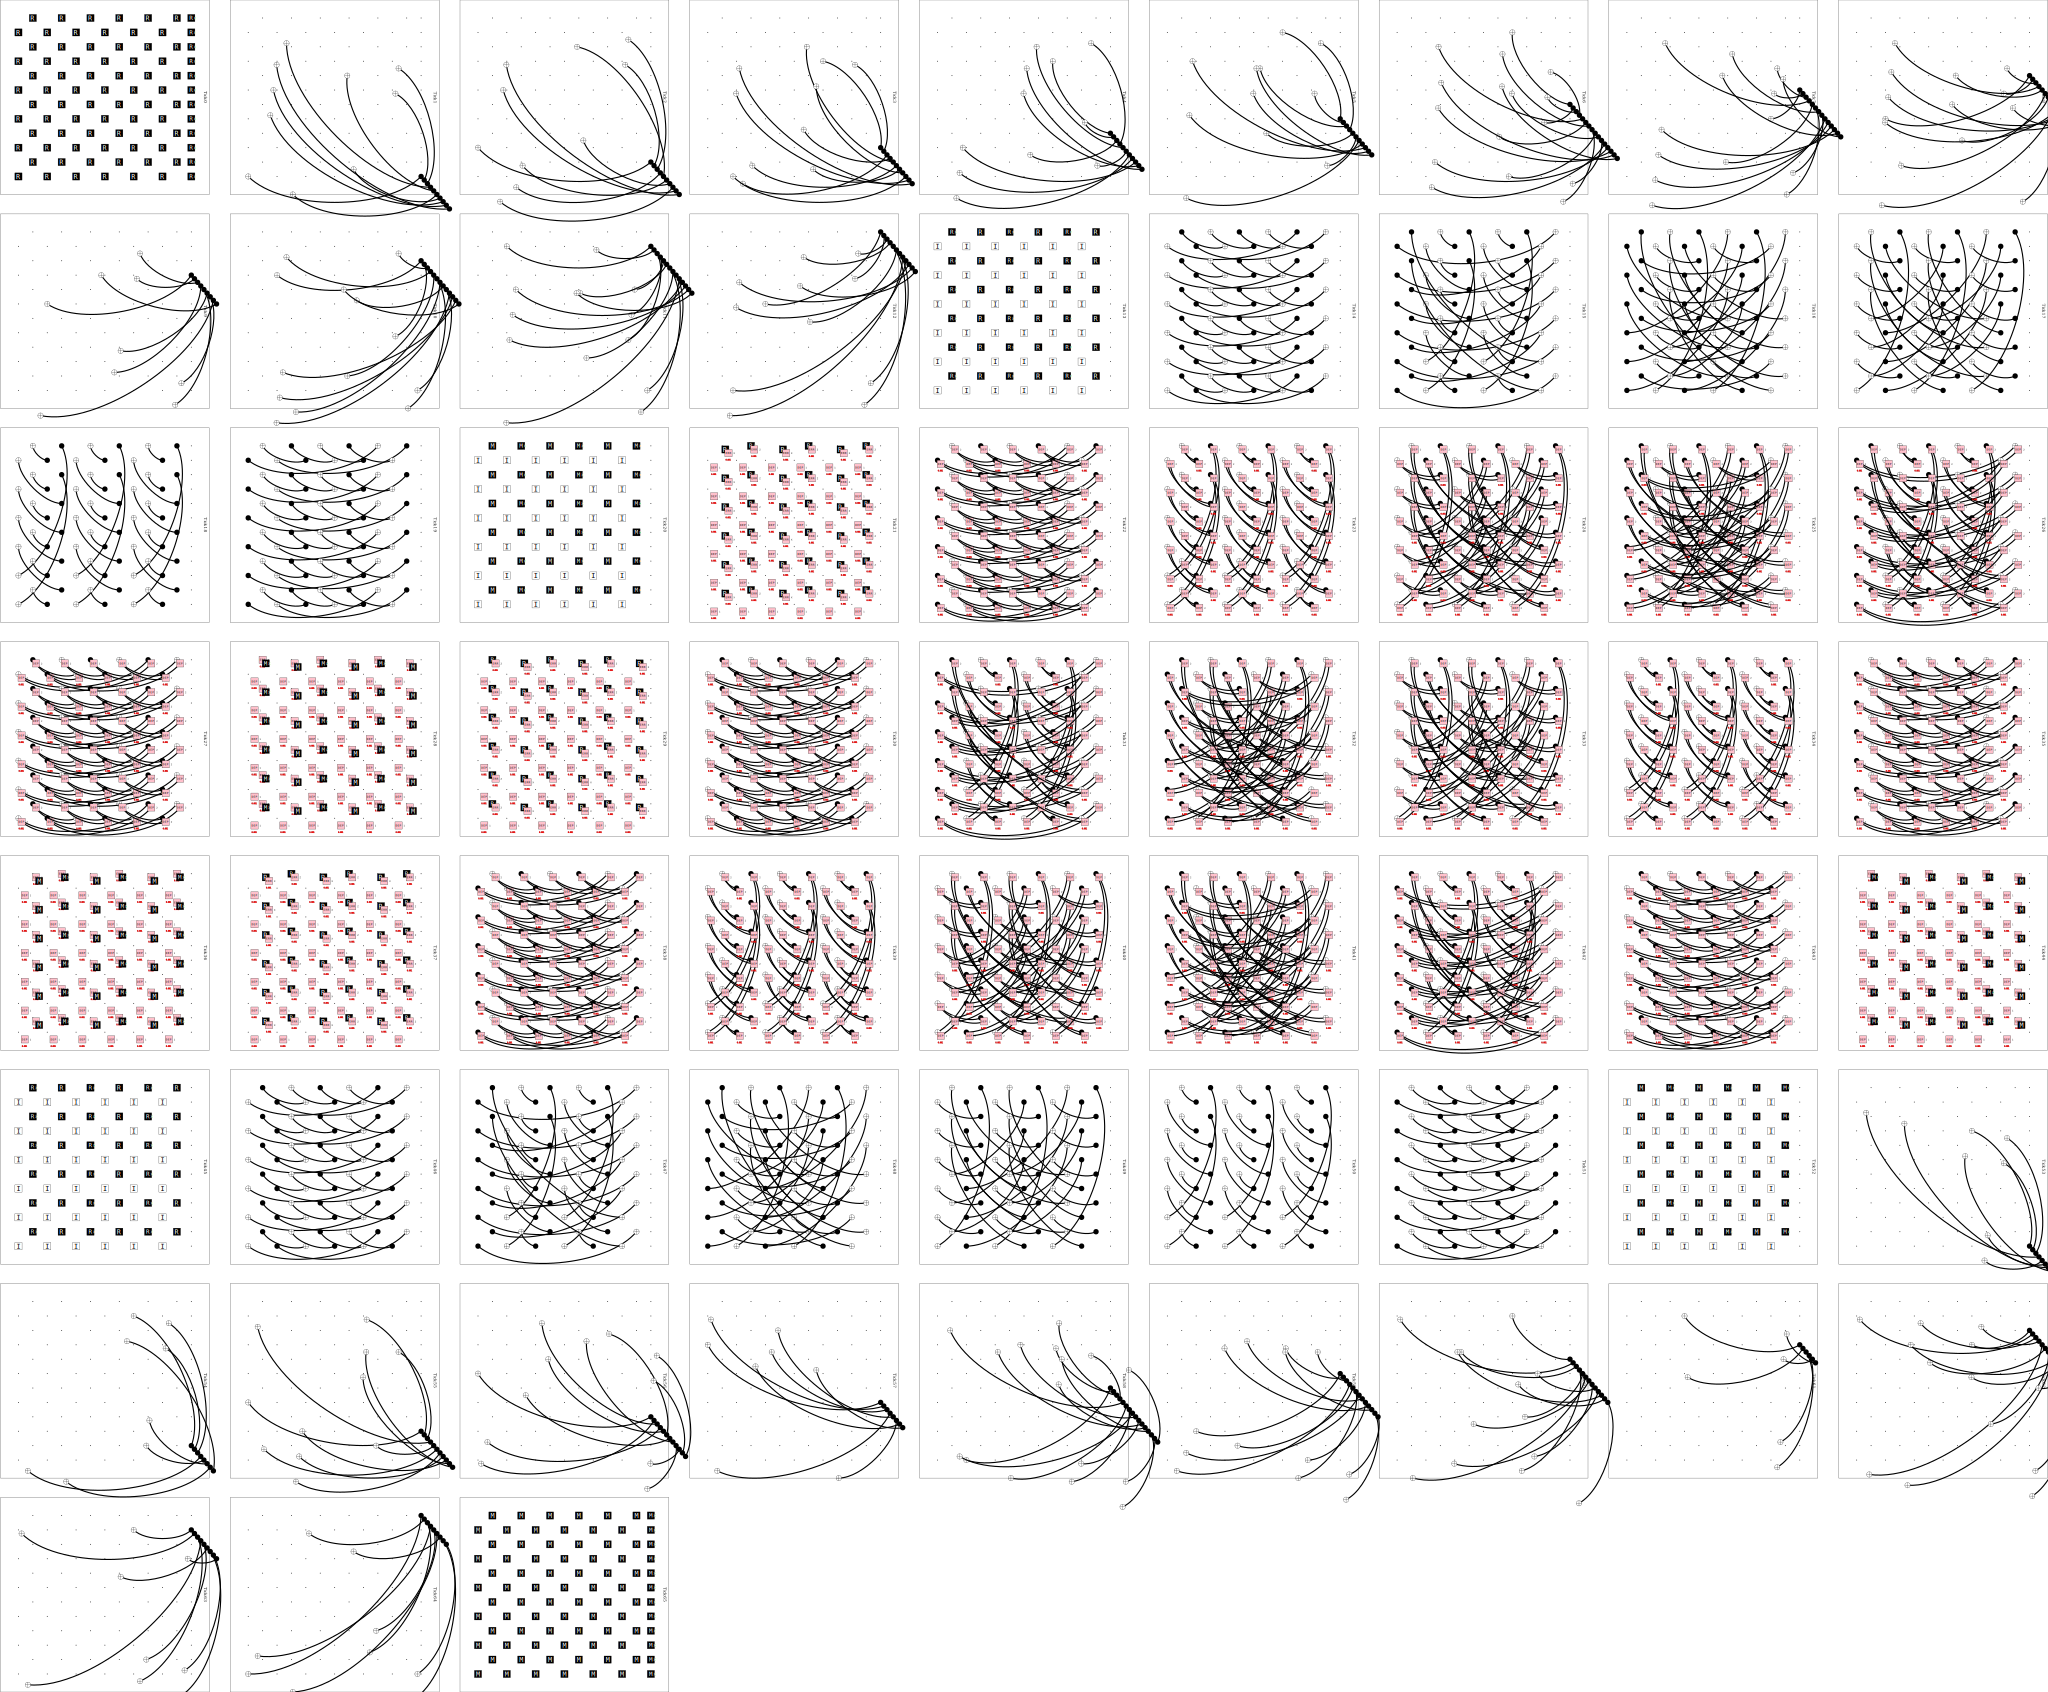

In [6]:
my_circuit.diagram('timeslice-svg')

#my_circuit.diagram('detslice-svg')

#observables_to_detectors(my_circuit).diagram('detslice-svg')

Now we can compile the sampler, detector error model, and decoder to run simulations. Here I use BP_OSD as my decoder.

In [7]:
from bp_osd import BP_OSD# available at https://github.com/MarcSerraPeralta/bp_osd
from morphing_qec_circuits.circuit_functions import bp_osd_kwargs

In [8]:
my_sampler = my_circuit.compile_detector_sampler()
my_dem = my_circuit.detector_error_model()
my_decoder = BP_OSD(my_dem, **bp_osd_kwargs)

In [9]:
sample_logical_flips(my_sampler, my_decoder, XZ_detector_indices = {}, target_flips = 10, batch_size = 1000, max_time = 60, separate_XZ = False)

100%|██████████| 1000/1000 [00:08<00:00, 112.56it/s]


(11, 4000)

When I ran this I got 11 flips in 4000 shots, which converts to a per-round error rate of $9.2\times 10^{-4}$. This is close to the value ($9.8\times 10^{-4}$) obtained in Fig 3 of `arXiv:2407.16336` for the morphing $[[36,12,3]]$ code.

One can also calculate an upper-bound on the circuit-level distance using a decoder. The parameters that I found best differ slightly from those above. Moreover, I use a different noise model that only inserts one type of Pauli noise after each gate.

In [10]:
from morphing_qec_circuits.circuit_distance_functions import circuit_distance_ub
from morphing_qec_circuits.distance_noise_model import DistanceNoiseModel

In [11]:
p = 0.0001
T = 2
noise_model_generator = lambda noise_setup, qubit_dictionary: DistanceNoiseModel(noise_setup, qubit_dictionary, "Z")#only adds Z-type noise

my_circuit_for_distance_ub = my_specs.get_morphing_XZ_memory_circuit(
    uniform_setup(p),
    T,
    noise_model_generator = noise_model_generator
)

basis = "X"# looking for flips to the X observable

bp_osd_kwargs_for_distance = {"bp_method": "product_sum", "osd_method": "osd_cs", "osd_order": 100, "max_bp_iters": 100}

initialise_decoder = lambda dem: BP_OSD(dem, **bp_osd_kwargs_for_distance)

In [12]:
n_shots = 100
circuit_distance_ub(my_circuit_for_distance_ub, initialise_decoder, n_shots = n_shots, basis = basis)

3

When I ran this for 100 shots I got a circuit-level distance upper-bound of 3. If you set `n_shots = None` then the code will search through all $2^{k}-1=4095$ logical configurations of the decoder.